In [1]:
# Import
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import matplotlib.pyplot as plt
#%matplotlib auto
cudnn.benchmark = True
cudnn.deterministic = True

In [2]:
# Read data from csv
import numpy as np
train_raw = pd.read_csv(os.path.join('../input/MINIST/MINIST','train.csv'))
train_lable = train_raw.iloc[:,0]
train_raw.drop(train_raw.columns[0],axis=1,inplace=True) 
test_raw = pd.read_csv(os.path.join('../input/MINIST/MINIST','test.csv'))
train_raw = train_raw.values.astype(np.uint8)
train_lable = train_lable.values.astype(np.uint8)
test_raw = test_raw.values.astype(np.uint8)

train_lable

array([1, 0, 1, ..., 7, 6, 9], dtype=uint8)

In [3]:
# resize dataset
train_x = train_raw.reshape(-1,28,28)
print(train_x[0].shape)
#cv2.imshow('first train image',train_x[0][0])
#cv2.waitKey(0)

(28, 28)


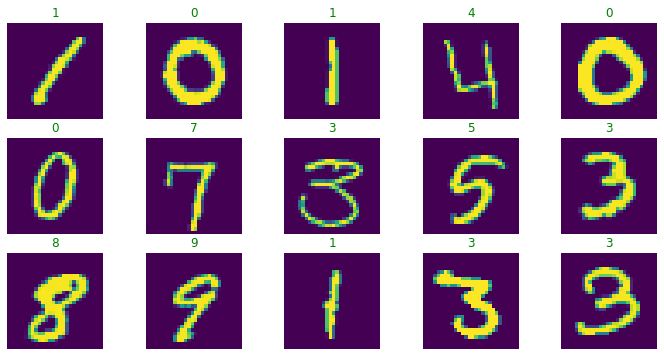

In [4]:
#显示样例
class fig_iter():
    def __init__(self,rows = 3,cols = 5):
        _, self.figs =  plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
        self.axlist = list(self.figs.flat)
        self.imgsize = rows * cols
        
    def step(self,images_list, lable_list,predicted_labels=()):
        for i, image_i in enumerate(images_list[0:self.imgsize]):
            self.axlist[i].cla()
            true_label = lable_list[i]
            predicted_label = predicted_labels[i] if predicted_labels else true_label
            color = "green" if true_label == predicted_label else "red"
            self.axlist[i].imshow(image_i)
            self.axlist[i].set_title(predicted_label, color=color)
            self.axlist[i].set_axis_off()
        
        plt.show()
    
display_iter = fig_iter()
display_iter.step(train_x,train_lable)

In [5]:
#定义数据预处理方法
img_prehandling = A.Compose([
    # Resize the img as 64*64 formate
    A.Normalize(mean=0.456, std=0.225),
    A.Resize(64,64),
    ToTensorV2()
])

img_augmentation_train = A.Compose([
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.456, std=0.225),
    ToTensorV2()
])

img_augmentation_validation = A.Compose([
    A.Resize(64,64),
    A.Normalize(mean=0.456, std=0.225),
    ToTensorV2()
])

In [6]:
#定义备用的数据预处理方法
img_prehandling2 = A.Compose([
    # Resize the img as 28*28 formate
    A.Normalize(mean=0.456, std=0.225),
    A.Resize(28,28),
    ToTensorV2()
])

img_augmentation_train2 = A.Compose([
    A.Resize(28,28),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=0.456, std=0.225),
    ToTensorV2()
])

img_augmentation_validation2 = A.Compose([
    A.Resize(28,28),
    A.Normalize(mean=0.456, std=0.225),
    ToTensorV2()
])

In [9]:
# 构建网络
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features_cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.features_cnn2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2, 2), stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.features_cnn3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(12, 12))
        
        self.classifier_FC1 = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2880, out_features=1024, bias=True),
            nn.ReLU(inplace=True)
        )
        
        self.classifier_FC2 = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=64, bias=True),
            nn.ReLU(inplace=True)
        )

        self.classifier_FC3 = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=64, out_features=64, bias=True),
            nn.ReLU(inplace=True)
        )
        
        
        self.classifier_FC4 = nn.Linear(in_features=64, out_features=10, bias=True)
        
        self.feature = nn.Sequential(
            self.features_cnn1,
            self.features_cnn2,
            self.features_cnn3
        )
        
        self.classifier = nn.Sequential(
            self.classifier_FC1,
            self.classifier_FC2,
            #self.classifier_FC3,
            self.classifier_FC4
        )
        
    def forward(self,x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = x.reshape(-1,2880)
        x = self.classifier(x)
        x.pred = nn.Softmax()(x)
        
        return x.pred


In [10]:
# 测试网络
model = AlexNet()
test_module_data = torch.Tensor(img_prehandling2(image = train_x[0])["image"].reshape(-1,1,28,28))
#test_module_data = torch.cat([test_module_data,test_module_data,test_module_data],dim=1)
x_featured = model(test_module_data)
print("test size:" ,test_module_data.size())
#nn.CrossEntropyLoss()(x_featured,x_featured)
x_featured.max(dim = 1)[1].cpu().numpy()
arr = x_featured.max(dim = 1)[1].cpu().numpy()
print(arr)
print(x_featured)
np.concatenate((arr,arr))

test size: torch.Size([1, 1, 28, 28])
[7]
tensor([[0.1033, 0.0916, 0.0993, 0.0961, 0.0992, 0.0975, 0.1014, 0.1106, 0.0922,
         0.1088]], grad_fn=<SoftmaxBackward>)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([7, 7])

In [11]:
# 制作训练集
class MINISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.Tensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
            #image = torch.cat([image,image,image],dim=0)
        return image,label

# Leave 50 samples for validation
train_dataset = MINISTDataset(images = train_x[0:-65],labels = train_lable[0:-65], transform= img_augmentation_train2)
validation_dataset = MINISTDataset(images = train_x[-65:], labels = train_lable[-65:],transform= img_augmentation_validation2)
test_dataset = MINISTDataset(images = test_raw.reshape(-1,28,28), labels = np.zeros((len(test_raw))),transform= img_augmentation_validation2)

In [12]:
# 定义hyper parameters
params = {
    "model": "AlexNet",
    "device": "cuda",
    "lr": 1e-4,
    "batch_size": 64,
    "num_workers": 0,
    "epochs": 10,
}

In [13]:
# 制作dataloader
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)

val_loader = DataLoader(
    validation_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [14]:
#根据网络层的不同定义不同的初始化方式     
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
     # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
# 将weight_init应用在子模块上
model.apply(weight_init)
#list(model.named_parameters())

AlexNet(
  (features_cnn1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features_cnn2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features_cnn3): Sequential(
    (0): Conv2d(64, 192, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(192, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(12, 12))
  (classifier_FC1): Sequential(
    (0): Dropout(p=0.5, inplace=Fal

In [15]:
# make model
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

pred: [3 1 2 1 1 4 5 8 4 9 7 9 4 8 7 4 1 1 4 1 3 4 7 2 9 1 8 9 2 8 2 4 6 0 9 2 3
 4 4 3 9 2 4 4 4 7 2 8 7 3 3 0 5 0 5 3 1 9 6 4 0 1 7 6]
real: tensor([3., 1., 2., 1., 1., 4., 5., 5., 4., 9., 7., 9., 4., 8., 7., 4., 1., 1.,
        4., 1., 3., 4., 7., 2., 9., 1., 8., 9., 2., 8., 2., 4., 6., 0., 9., 2.,
        3., 4., 4., 3., 9., 2., 4., 4., 4., 7., 2., 8., 7., 3., 3., 0., 5., 0.,
        5., 3., 1., 9., 6., 4., 0., 1., 7., 6.], device='cuda:0')
Epoch:  4 | train loss: 1.4701 | test accuracy: 0.98


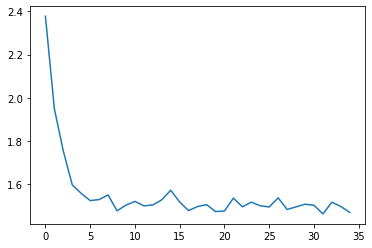

In [16]:
#开始训练
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from IPython import display

EPOCH = 5
loss_trend = list()
acc_trend = list()
model.to(params["device"])
criterion = criterion.to(params["device"])

#training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = torch.autograd.Variable(x.to(params["device"]))   # batch x
        b_y = torch.autograd.Variable(y.to(params["device"]))   # batch y
        
        #plt.imshow(torch.cat([b_x,b_x,b_x],dim=1).cpu())

        output = model(b_x)
        
        loss = criterion(output, b_y.long())
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        loss = loss.item()
        
        #训练中显示精度或者保存网络，这里没有进行网络的保存
        if step % 100 == 0:
            display.clear_output(wait=True)
            _, (x_v, y_v) = next(iter(enumerate(val_loader)))
            x_v = torch.autograd.Variable(x_v.to(params["device"]))   # batch x
            y_v = torch.autograd.Variable(y_v.to(params["device"]))   # batch y
            
            test_output = model(x_v)
            pred_y = test_output.max(dim = 1)[1].cpu().numpy()
            print("pred:",pred_y)
            print("real:",y_v)
            #print(pred_y == y_v.cpu().numpy())
            #print("This real = ", b_y)
            #print("This pred = ", output)
            
            
            accuracy = (pred_y == y_v.cpu().numpy()).sum().item() / float(y_v.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
            loss_trend.append(loss)
            acc_trend.append(accuracy)
            plt.plot(loss_trend)
            plt.show()
            del x_v
            del y_v
            del test_output
            del output
            del b_x
            del b_y
    plt.ioff()

In [17]:
#开始预测
predictions = np.array([])
next(iter(enumerate(test_loader)))
# Generate test results
for step, (x , y) in enumerate(test_loader):
    b_x = torch.autograd.Variable(x).to(params["device"])

    output = model(b_x)
    
    if step % 50 == 0:
        print("step = ", step)
    
    #转化为numpy
    temp_arr = output.max(dim = 1)[1].cpu().numpy()
    predictions = np.concatenate((predictions,temp_arr))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


step =  0
step =  50
step =  100
step =  150
step =  200
step =  250
step =  300
step =  350
step =  400


In [18]:
predictions.shape

(28000,)

In [19]:
## 保存模型
torch.save(model, 'model_name.pth')


In [20]:
## 保存数据
submission = pd.read_csv('../input/MINIST/sample_submission.csv')
submission.iloc[:,1] = predictions.astype(np.int16)
submission.set_index(["ImageId"], inplace=True)
submission.to_csv('submission.csv')
submission


,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3
